In [183]:
import io
import base64
import cv2
import imageio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.spatial.distance import cdist
from PIL import Image as PILImage  # 避免與 IPython.display.Image 衝突
from IPython.display import display, HTML

def load_image(image_path, scale=0.5):
    img = cv2.imread(image_path)  # 讀取圖片
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 轉換為 RGB
    img = cv2.resize(img, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_AREA)  # 縮小解析度
    
    h, w, _ = img.shape
    coordinates = np.array([[i, j] for i in range(h) for j in range(w)])
    colors = img.reshape(-1, 3)  # 展平顏色資訊
    return coordinates, colors, h, w

coordinates1, colors1, h1, w1 = load_image("image1.png", scale=0.5)  
coordinates2, colors2, h2, w2 = load_image("image2.png", scale=0.5)


In [169]:
# 創建黑色、橙色、天藍色和灰色顏色映射
custom_cmap = ListedColormap(['black', 'darkorange', 'cornflowerblue', 'silver', 
	'gold', 'green', 'navy', 'magenta', 'yellow', 'red', 'peru', 'pink', 
	'dodgerblue', 'greenyellow', 'cyan']
)

def rbf_kernel(coordinates, colors, gamma_s, gamma_c):
    spatial_dist = np.linalg.norm(coordinates[:, np.newaxis] - coordinates, axis=2) ** 2
    # Calculate color distance (squared)
    color_dist = np.linalg.norm(colors[:, np.newaxis] - colors, axis=2) ** 2
    # Compute the RBF kernel
    kernel = np.exp(-gamma_s * spatial_dist) * np.exp(-gamma_c * color_dist)
    return kernel

def kernel_k_means(K, n_clusters, max_iter=1000):
    n = K.shape[0]
    cluster_assignments = np.random.choice(n_clusters, n)
    for iteration in range(max_iter):
        # Compute the sum of similarities for each cluster
        cluster_sums = np.array([np.sum(K[:, cluster_assignments == k], axis=1) for k in range(n_clusters)])
        cluster_sizes = np.array([np.sum(cluster_assignments == k) for k in range(n_clusters)])
        # Avoid division by zero
        cluster_sizes = np.maximum(cluster_sizes, 1e-6)
        # Compute cluster means
        cluster_means = cluster_sums / cluster_sizes[:, None]
        # Update assignments
        new_assignments = np.argmax(cluster_means, axis=0)
        # Check for convergence
        if np.array_equal(new_assignments, cluster_assignments):
            break
        cluster_assignments = new_assignments
    return cluster_assignments


def kmeans_manual(X, n_clusters, max_iter=1000, tol=1e-4):
    n_samples, n_features = X.shape
    centers = X[np.random.choice(n_samples, n_clusters, replace=False)]  # 初始化中心點
    
    for _ in range(max_iter):
        # 計算每個點到中心點的距離
        distances = cdist(X, centers, metric="euclidean")
        labels = np.argmin(distances, axis=1)
        
        new_centers = np.zeros_like(centers)
        for i in range(n_clusters):
            points_in_cluster = X[labels == i]
            if len(points_in_cluster) > 0:
                new_centers[i] = points_in_cluster.mean(axis=0)
            else:
                # 如果某個叢集沒有點，保留原先的中心或重新隨機初始化
                new_centers[i] = centers[i]  # 這裡選擇保留原中心
        
        # 判斷是否收斂
        if np.linalg.norm(new_centers - centers) < tol:
            break
        centers = new_centers
        
    return labels


def spectral_clustering(K, n_clusters, method="normalized"):
    n = K.shape[0]
    D = np.diag(np.sum(K, axis=1))
    if method == "normalized":
        D_inv_sqrt = np.diag(1.0 / np.sqrt(np.maximum(np.sum(K, axis=1), 1e-6)))  # 避免 0 除錯誤
        L = np.eye(n) - D_inv_sqrt @ K @ D_inv_sqrt
    else:
        L = D - K
    # 計算特徵向量
    _, eigvecs = np.linalg.eigh(L)
    cluster_data = eigvecs[:, 1:n_clusters+1]
    # 使用 k-means 分群
    labels = kmeans_manual(cluster_data, n_clusters)
    return labels

def kmeans_plus_kernel(K, n_clusters):
    n = K.shape[0]
    centers_idx = [np.random.choice(n)]  # Randomly choose the first centroid

    for _ in range(1, n_clusters):
        # Ensure the chosen centroids are within the bounds
        if any(idx >= K.shape[1] for idx in centers_idx):
            raise ValueError(f"Index out of bounds in centers_idx: {centers_idx}")

        # Calculate the minimum distance of each point to the chosen centroids
        dist_to_centers = np.min(K[np.ix_(range(n), centers_idx)], axis=1)
        dist_to_centers = np.maximum(dist_to_centers, 1e-8)   # Avoid zero distance
        probabilities = dist_to_centers / dist_to_centers.sum()

        # Select the next centroid based on the calculated probabilities
        next_center_idx = np.random.choice(n, p=probabilities)
        centers_idx.append(next_center_idx)

    return centers_idx

def kernel_kmeans_plus(K, n_clusters, max_iter=10):
    n = K.shape[0]
    # Initialize centroids using K-means++ method
    initial_centers_idx = kmeans_plus_kernel(K, n_clusters)
    # Initialize the cluster assignments for each point
    cluster_assignments = np.zeros(n, dtype=int)

    for iteration in range(max_iter):
        # Calculate the distance of each point to the centroids
        distances = np.zeros((n, n_clusters))
        for k, center_idx in enumerate(initial_centers_idx):
            # Use the kernel distance formula to calculate the distance
            distances[:, k] = (
                K.diagonal()
                - 2 * K[:, center_idx]
                + K[center_idx, center_idx]
            )

        # Assign each point to the closest centroid
        new_assignments = np.argmin(distances, axis=1)

        # Check if the algorithm has converged (assignments didn't change)
        if np.array_equal(new_assignments, cluster_assignments):
            break
        cluster_assignments = new_assignments

    return cluster_assignments


def visualize_all_clusters(K, n_clusters, h, w, custom_cmap, original_img_file):
    
    # 取得三種分群結果
    kernel_assignments = kernel_k_means(K, n_clusters)
    normalized_assignments = spectral_clustering(K, n_clusters, method="normalized")
    ratio_assignments = spectral_clustering(K, n_clusters, method="unnormalized")
    kmeans_plus_assignments = kernel_kmeans_plus(K, n_clusters)

    
    # 讀取原圖 (使用 PILImage 避免衝突)
    original_img = PILImage.open(original_img_file)

    # 轉換分群結果為 RGB 圖片
    kernel_img = PILImage.fromarray((custom_cmap(kernel_assignments.reshape(h, w) / n_clusters)[:, :, :3] * 255).astype(np.uint8))
    normalized_img = PILImage.fromarray((custom_cmap(normalized_assignments.reshape(h, w) / n_clusters)[:, :, :3] * 255).astype(np.uint8))
    ratio_img = PILImage.fromarray((custom_cmap(ratio_assignments.reshape(h, w) / n_clusters)[:, :, :3] * 255).astype(np.uint8))
    kmeans_plus_img = PILImage.fromarray((custom_cmap(kmeans_plus_assignments.reshape(h, w) / n_clusters)[:, :, :3] * 255).astype(np.uint8))

    # 確保所有圖片大小一致
    width, height = original_img.size
    kernel_img = kernel_img.resize((width, height))
    normalized_img = normalized_img.resize((width, height))
    ratio_img = ratio_img.resize((width, height))
    kmeans_plus_img = kmeans_plus_img.resize((width, height))

    # 顯示圖片在 **同一行**，標題**置中**
    display(HTML(
        f"""
        <div style="display: flex; justify-content: center; align-items: center; gap: 20px;">
            <div style="text-align: center;">
                <p style="font-weight: bold; margin-bottom: 5px;">Ground Truth</p>
                <img src="{save_temp_image(original_img)}" width="{width}" height="{height}">
            </div>
            <div style="text-align: center;">
                <p style="font-weight: bold; margin-bottom: 5px;">Kernel K-Means</p>
                <img src="{save_temp_image(kernel_img)}" width="{width}" height="{height}">
            </div>
            <div style="text-align: center;">
                <p style="font-weight: bold; margin-bottom: 5px;">Normalized Cut</p>
                <img src="{save_temp_image(normalized_img)}" width="{width}" height="{height}">
            </div>
            <div style="text-align: center;">
                <p style="font-weight: bold; margin-bottom: 5px;">Ratio Cut</p>
                <img src="{save_temp_image(ratio_img)}" width="{width}" height="{height}">
            </div>
            <div style="text-align: center;">
                <p style="font-weight: bold; margin-bottom: 5px;">kmeans_plus</p>
                <img src="{save_temp_image(kmeans_plus_img)}" width="{width}" height="{height}">
            </div>
        </div>
        """
    ))

    return kernel_img, normalized_img, ratio_img, kmeans_plus_img



def save_temp_image(img):
    """將 PIL Image 轉換為 base64 編碼，並回傳 HTML 可用的 data URI"""
    img_io = io.BytesIO()
    img.save(img_io, format="PNG")
    img_base64 = base64.b64encode(img_io.getvalue()).decode("utf-8")
    return f"data:image/png;base64,{img_base64}"


Part 1,2

image 1


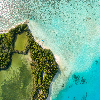
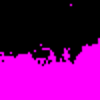
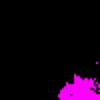
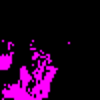
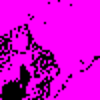

In [171]:
gamma_s = 1e-2
gamma_c = 1e-4
n_clusters = 2

K = rbf_kernel(coordinates1, colors1, gamma_s, gamma_c)

kernel_img, normalized_img, ratio_img, kmeans_plus_img = visualize_all_clusters(K, n_clusters, h1, w1, custom_cmap, "image1.png")



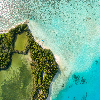
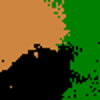
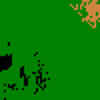
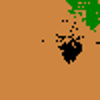
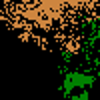

In [173]:
n_clusters = 3

K = rbf_kernel(coordinates1, colors1, gamma_s, gamma_c)

kernel_img, normalized_img, ratio_img, kmeans_plus_img = visualize_all_clusters(K, n_clusters, h1, w1, custom_cmap, "image1.png")



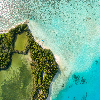
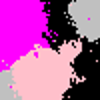
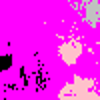
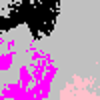
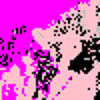

In [174]:
n_clusters = 4

K = rbf_kernel(coordinates1, colors1, gamma_s, gamma_c)

kernel_img, normalized_img, ratio_img, kmeans_plus_img = visualize_all_clusters(K, n_clusters, h1, w1, custom_cmap, "image1.png")

image 2


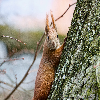
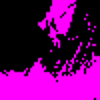
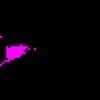
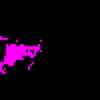
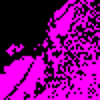

In [177]:
n_clusters = 2

K = rbf_kernel(coordinates2, colors2, gamma_s, gamma_c)

kernel_img, normalized_img, ratio_img, kmeans_plus_img = visualize_all_clusters(K, n_clusters, h2, w2, custom_cmap, "image2.png")


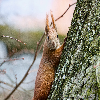
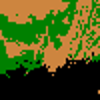
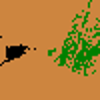
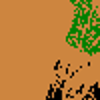
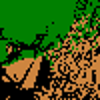

In [178]:
n_clusters = 3

K = rbf_kernel(coordinates2, colors2, gamma_s, gamma_c)

kernel_img, normalized_img, ratio_img, kmeans_plus_img = visualize_all_clusters(K, n_clusters, h2, w2, custom_cmap, "image2.png")


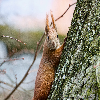
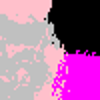
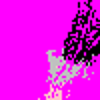
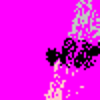
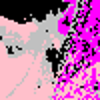

In [179]:
n_clusters = 4

K = rbf_kernel(coordinates2, colors2, gamma_s, gamma_c)

kernel_img, normalized_img, ratio_img, kmeans_plus_img = visualize_all_clusters(K, n_clusters, h2, w2, custom_cmap, "image2.png")